We are making clusters out of the embedded data. These clusters represent the data of each individual for categorization purposes

In [1]:

from utils import save_face_list, extract_frames
from face_extraction import process_image, check_face
from facenet_pytorch import MTCNN
import torch
import cv2
from pathlib import Path  # import Path from pathlib module
from embed import embed_face_net
from main_unsupervised import find_best_number_of_clusters
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import os
import shutil
import plots
import augmentation
import main_embed




In [2]:
MOVIE_FOLDER = "C:\\Users\\ningw\\Desktop\\"

FACES_FOLDER_TRAINING = 'C:\\Users\\ningw\\Desktop\\Assignment 3\\KTA3\\face_folder\\'
FACES_FOLDER_TEST = 'C:\\Users\\ningw\\Desktop\\Assignment 3\\KTA3\\face_folder_test\\'

OUTPUT_FOLDER_RESULTS_TRAIN = 'C:\\Users\\ningw\\Desktop\\Assignment 3\\KTA3\\results\\'
RESULTS_NAME_TRAIN = 'second_results.csv'
RESULTS_CSV_TRAIN = 'results\\second_results.csv'

OUTPUT_FOLDER_RESULTS_TEST = 'C:\\Users\\ningw\\Desktop\\Assignment 3\\KTA3\\results_test\\'
RESULTS_NAME_TEST = 'test_results.csv'
RESULTS_CSV_TEST = 'C:\\Users\\ningw\\Desktop\\Assignment 3\\KTA3\\results_test\\test_results.csv'

KMEANS_OUTPUT_FOLDER = 'KMEANS_OUTPUT'
CLUSTER_MODEL_PATH = 'C:\\Users\\ningw\\Desktop\\Assignment 3\\KTA3\\KMEANS_OUTPUT\\kmeans.pkl'

directories = [MOVIE_FOLDER,FACES_FOLDER_TRAINING,FACES_FOLDER_TEST,OUTPUT_FOLDER_RESULTS_TRAIN,OUTPUT_FOLDER_RESULTS_TEST,KMEANS_OUTPUT_FOLDER]
for path in directories:
    if not os.path.isdir(path):
        os.makedirs(path, exist_ok=True)
        print(f"Checked/Created directory: {path}")
    else: 
        print(f"Directory already exists: {path}")


Directory already exists: Desktop
Directory already exists: face_folder
Directory already exists: face_folder_test
Directory already exists: results
Directory already exists: results_test
Directory already exists: KMEANS_OUTPUT


In [ ]:

cap = cv2.VideoCapture(MOVIE_FOLDER+MOVIE_TRAINING_LIST[1]+'.mp4')
if not cap.isOpened():
    print("Error: Cannot open video file.")
else:
    print("Video file opened successfully!")
cap.release()


In [ ]:
output_extension= '.png'
input_extension = '.mp4'
samples_per_second = 10         #FPS rate is assumed 25
padding_x = 10
padding_y = 10
min_confidence = 0.5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)

for movie in MOVIE_TRAINING_LIST:
  print(movie+input_extension)
  frame_list = extract_frames(MOVIE_FOLDER,movie+input_extension,samples_per_second)
  face_list_movie = []
  for frame in frame_list:
    face_list_frame = process_image(frame,padding_x,padding_y,min_confidence)
    for face in face_list_frame:
      if check_face(face,mtcnn):
        face_list_movie.append(face)
  print('saving')
  save_face_list(face_list_movie,FACES_FOLDER_TRAINING,movie,output_extension)

In [ ]:
main_embed.embed(FACES_FOLDER_TRAINING, OUTPUT_FOLDER_RESULTS_TRAIN,RESULTS_NAME_TRAIN)


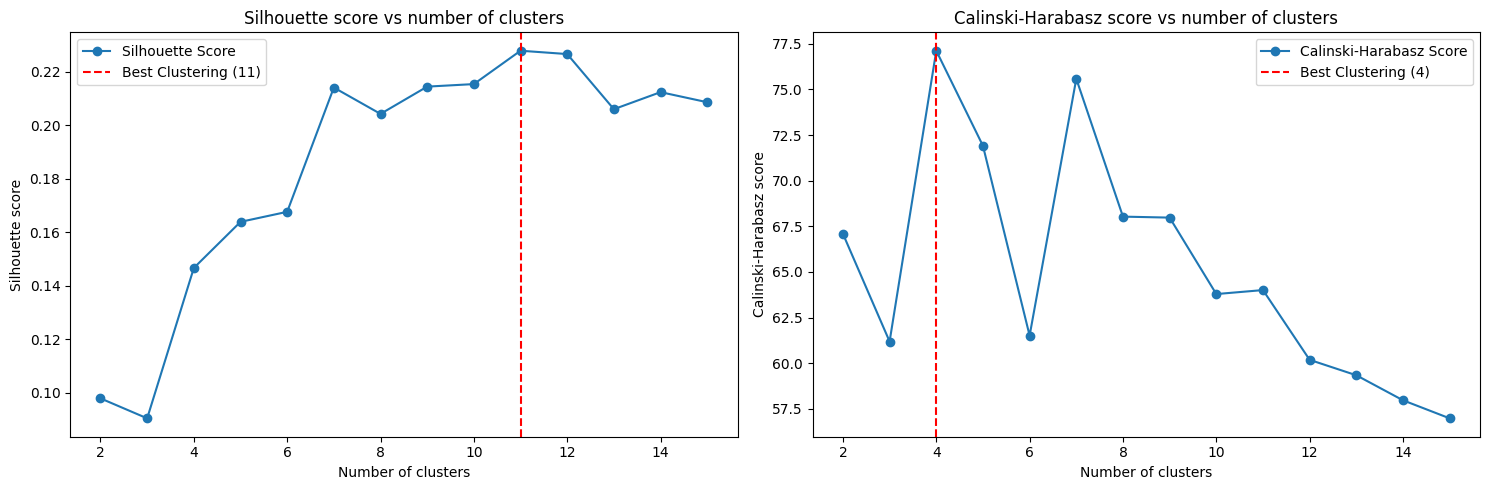

In [4]:
best_clusters_silhouette, best_clusters_calinski = find_best_number_of_clusters(RESULTS_CSV_TRAIN)
cluster_choice = best_clusters_calinski


In [ ]:
for movie in MOVIE_TEST_LIST:
  print(movie+input_extension)
  frame_list = extract_frames(MOVIE_FOLDER,movie+input_extension,samples_per_second)
  face_list_movie = []
  for frame in frame_list:
    face_list_frame = process_image(frame,padding_x,padding_y,min_confidence)
    for face in face_list_frame:
      if check_face(face,mtcnn):
        face_list_movie.append(face)
  print('saving')
  save_face_list(face_list_movie,FACES_FOLDER_TEST,movie,output_extension)

In [ ]:
main_embed.embed(FACES_FOLDER_TEST+"/",OUTPUT_FOLDER_RESULTS_TEST,RESULTS_NAME_TEST)


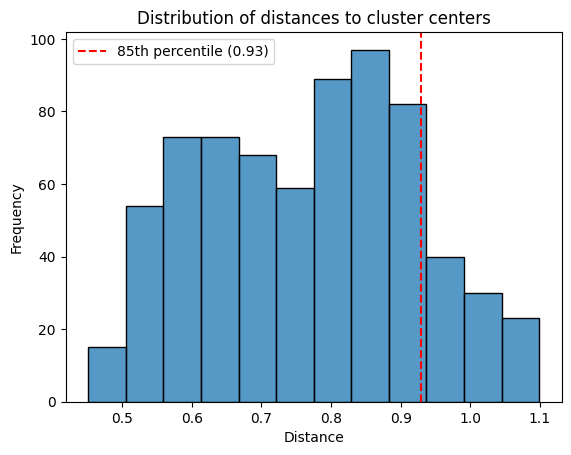

In [5]:

train_embeddings_df = pd.read_csv(RESULTS_CSV_TRAIN)
trains_embeddings = train_embeddings_df.T.values
test_embeddings_df = pd.read_csv(RESULTS_CSV_TEST)
test_embeddings = test_embeddings_df.T.values

kmeans = KMeans(random_state=0, n_clusters=cluster_choice).fit(trains_embeddings)
labels = kmeans.labels_

distances_train = pairwise_distances_argmin_min(trains_embeddings, kmeans.cluster_centers_)[1]
threshold_distance_85 = np.percentile(distances_train, 85)

plots.plot_histplot_percentile(distances_train, threshold_distance_85)

for i, file_name in enumerate(train_embeddings_df.columns):
    if distances_train[i] > threshold_distance_85:
        train_embeddings_df.drop(file_name, axis='columns', inplace=True)
    
trains_embeddings = train_embeddings_df.T.values
kmeans = KMeans(random_state=0, n_clusters=cluster_choice, max_iter=600).fit(trains_embeddings)
labels = kmeans.labels_

for i, file_name in enumerate(train_embeddings_df.columns):
    src_path = os.path.join(FACES_FOLDER_TRAINING, file_name)
    if distances_train[i] > threshold_distance_85:
        dst_path = os.path.join(KMEANS_OUTPUT_FOLDER, 'outliers', file_name)
    else:   
        dst_path = os.path.join(KMEANS_OUTPUT_FOLDER, f'cluster_{labels[i]}', file_name)
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    shutil.copy(src_path, dst_path)
    


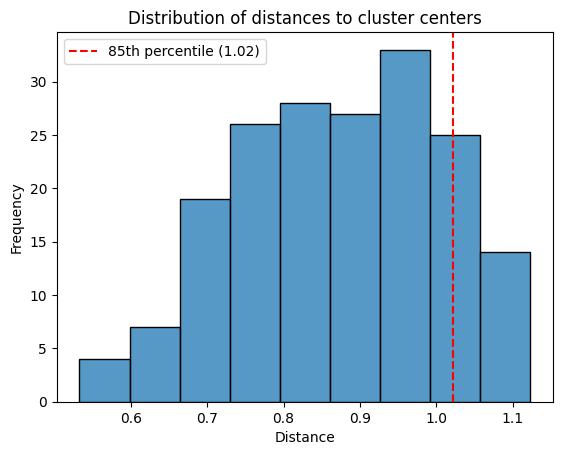

Image face_folder_testTest_148.png belongs to Cluster 0
Image face_folder_testTest_160.png belongs to Cluster 2
Image face_folder_testTest_174.png belongs to Cluster 1
Image face_folder_testTest_12.png belongs to Cluster -1
Image face_folder_testTest_175.png belongs to Cluster 1
Image face_folder_testTest_13.png belongs to Cluster 1
Image face_folder_testTest_161.png belongs to Cluster 2
Image face_folder_testTest_149.png belongs to Cluster 1
Image face_folder_testTest_39.png belongs to Cluster 1
Image face_folder_testTest_11.png belongs to Cluster -1
Image face_folder_testTest_177.png belongs to Cluster -1
Image face_folder_testTest_163.png belongs to Cluster 2
Image face_folder_testTest_162.png belongs to Cluster 2
Image face_folder_testTest_10.png belongs to Cluster 1
Image face_folder_testTest_176.png belongs to Cluster 1
Image face_folder_testTest_38.png belongs to Cluster 2
Image face_folder_testTest_172.png belongs to Cluster 1
Image face_folder_testTest_14.png belongs to Cluste

In [6]:
predicted_clusters = kmeans.predict(test_embeddings)      
distances_test = pairwise_distances_argmin_min(test_embeddings, kmeans.cluster_centers_)[1]
threshold_distance_85 = np.percentile(distances_test,85)

plots.plot_histplot_percentile(distances_test,threshold_distance_85)

image_cluster_results = []
for i, cluster in enumerate(predicted_clusters):
    if distances_test[i] > threshold_distance_85:
        cluster = -1
    
    image_cluster_results.append({
        "Image": test_embeddings_df.columns[i],
        "Cluster": cluster
    })
    print(f"Image {test_embeddings_df.columns[i]} belongs to Cluster {cluster}")

# Save image-to-cluster mapping
results_df = pd.DataFrame(image_cluster_results)
results_output_path = 'image_to_cluster_results.csv'
results_df.to_csv(results_output_path, index=False)
# Define the output folder
output_folder = 'recognition-output'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Load the image-to-cluster mapping
image_to_cluster_path = 'image_to_cluster_results.csv'
image_cluster_results = pd.read_csv(image_to_cluster_path)

# Iterate through the mapping and organize images into cluster folders
for _, row in image_cluster_results.iterrows():
    image_name = row['Image']
    cluster = row['Cluster']
    
    # Create a subfolder for the cluster if it doesn't exist
    cluster_folder = os.path.join(output_folder, f'Cluster_{cluster}')
    os.makedirs(cluster_folder, exist_ok=True)
    
    # Define the source and destination paths
    source_path = os.path.join('face_folder_test', image_name)  # Adjust source folder if needed
    destination_path = os.path.join(cluster_folder, image_name)
    
    # Copy the image to the cluster folder
    if os.path.exists(source_path):
        shutil.copy(source_path, destination_path)

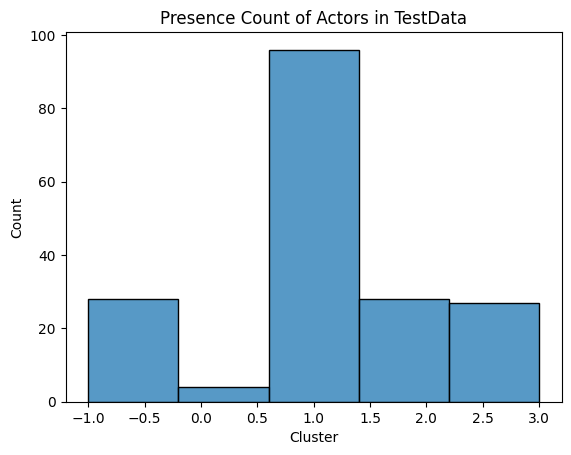

In [7]:
plots.plot_actor_presence(results_df,'Cluster',cluster_choice)

In [ ]:
augmentation.process_images_with_augmentations(FACES_FOLDER_TEST,'AUGMENTED')

In [14]:

def process_videos_to_dataframe(movie_test_list, movie_folder, kmeans, samples_per_second=10,padding_x=10,padding_y=10,min_confidence=0.5):
    
    cluster_presence = pd.DataFrame()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    mtcnn = MTCNN(keep_all=True, device=device)
    for movie in movie_test_list:
        print(f"Processing {movie + '.mp4'}")
        frame_list = extract_frames(movie_folder, movie + '.mp4', samples_per_second)
        cluster_frame_data = []

        for frame_idx, frame in enumerate(frame_list):
            face_list_frame = process_image(frame, padding_x, padding_y, min_confidence)
            frame_clusters = []

            for face in face_list_frame:
                if check_face(face, mtcnn):
                    embedding = embed_face_net(face).flatten()
                    embedding_reshaped = embedding.reshape(1, -1)

                    if pairwise_distances_argmin_min(embedding_reshaped, kmeans.cluster_centers_)[1] > threshold_distance_85:
                        cluster = -1
                    else:
                        cluster = int(kmeans.predict(embedding_reshaped)[0])
                    frame_clusters.append(cluster)
                    
            cluster_frame_data.append(frame_clusters)

        for frame_idx, clusters in enumerate(cluster_frame_data):
            for cluster in clusters:
                cluster_presence.loc[cluster, frame_idx] = 1


    cluster_presence.fillna(0, inplace=True)

    return cluster_presence


In [15]:
cluster_dataframe = process_videos_to_dataframe(MOVIE_TEST_LIST, MOVIE_FOLDER, kmeans)

Processing Test.mp4
Start extracting frames
Successfully captured 521 frames


I0000 00:00:1744291132.266785  441803 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
W0000 00:00:1744291132.273892  444729 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1744291132.281658  441803 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
W0000 00:00:1744291132.282771  444739 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1744291132.287600  441803 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
W0000 00:00:1744291132.288682  444748 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1744291132.292901  441803 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: App

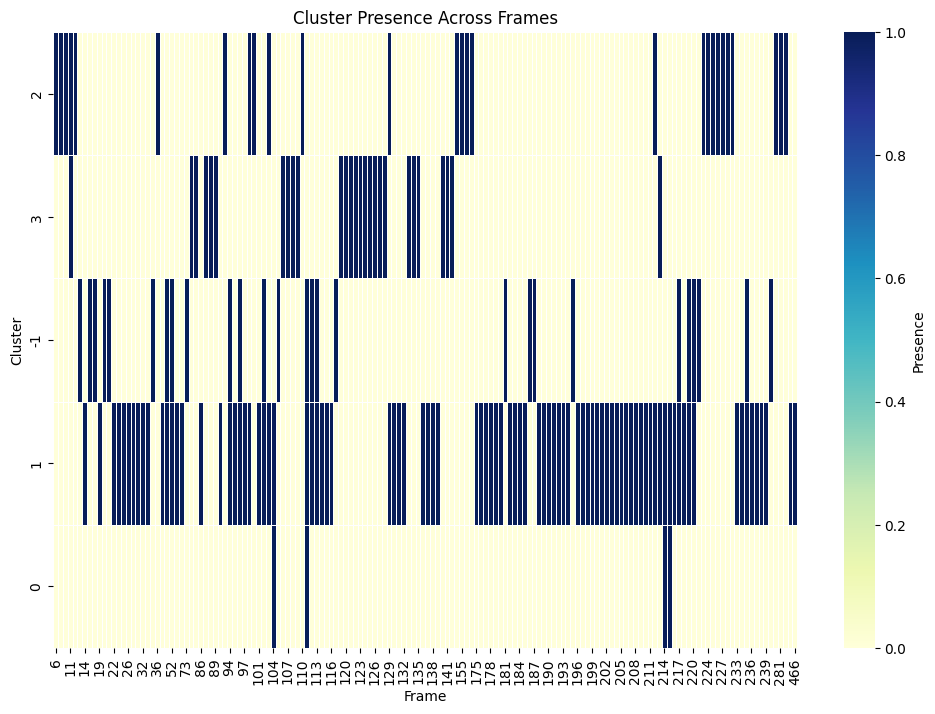

In [16]:
plots.plot_cluster_presence(cluster_dataframe)